In [1]:
from functools import partial

from tqdm.notebook import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import equinox as eqx
import diffrax
import optax

from jaxtyping import Float, Array, PRNGKeyArray

key = jax.random.key(42)

### 1. Review the results of the ConservNet model applied to the 2D Kepler (Sun-Earth) configuration. If the results are not satisfactory, provide a detailed analysis and discussion. (60pts)

In [2]:
## DEMO KEPLER DATASET GENERATION CODE

import math
import numpy as np

class Point:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

class Body:
    def __init__(self, location, mass, velocity, name=""):
        self.location = location
        self.mass = mass
        self.velocity = velocity
        self.name = name

def run_simulation(bodies, dt=1, steps=10000):
    G = 6.67408e-11

    # Initialize the history of body locations and velocities
    history = [{"name": body.name, "x": [], "y": [], "z": [], "vx": [], "vy": [], "vz": []} for body in bodies]

    for step in range(1, steps + 1):
        # Calculate accelerations
        accelerations = [Point(0, 0, 0) for _ in bodies]
        for i, target_body in enumerate(bodies):
            for j, external_body in enumerate(bodies):
                if i != j:
                    dx = external_body.location.x - target_body.location.x
                    dy = external_body.location.y - target_body.location.y
                    dz = external_body.location.z - target_body.location.z
                    r_squared = dx**2 + dy**2 + dz**2
                    r = math.sqrt(r_squared)
                    factor = G * external_body.mass / r_squared**1.5
                    accelerations[i].x += factor * dx
                    accelerations[i].y += factor * dy
                    accelerations[i].z += factor * dz

        # Update velocities and positions
        for i, body in enumerate(bodies):
            body.velocity.x += accelerations[i].x * dt
            body.velocity.y += accelerations[i].y * dt
            body.velocity.z += accelerations[i].z * dt
            if body.name != 'sun':
                body.location.x += body.velocity.x * dt
                body.location.y += body.velocity.y * dt
                body.location.z += body.velocity.z * dt

        # Record data
        if step % int(1/dt) == 0:
            for i, body in enumerate(bodies):
                hist = history[i]
                hist["x"].append(body.location.x)
                hist["y"].append(body.location.y)
                hist["z"].append(body.location.z)
                hist["vx"].append(body.velocity.x)
                hist["vy"].append(body.velocity.y)
                hist["vz"].append(body.velocity.z)

    return history

def system_P2(batch_size):
    counter = 0
    G = 6.67408e-11
    while True:
        loc1 = np.random.uniform(-5, 5)
        loc2 = np.random.uniform(-5, 5)
        vel1 = np.random.uniform(-5, 5)
        vel2 = np.random.uniform(-5, 5)

        sun = Body(Point(0, 0, 0), 1/G, Point(0, 0, 0), "sun")
        earth = Body(Point(loc1, loc2, 0), 1, Point(vel1, vel2, 0), "earth")

        bodies = [sun, earth]
        burn_steps = 3
        dt = 0.01
        results = run_simulation(bodies, dt=dt, steps=int((1/dt)*(batch_size+burn_steps)+1))

        # Save earth's position & velocity information
        x = np.array(results[1]['x'][burn_steps:])
        y = np.array(results[1]['y'][burn_steps:])
        vx = np.array(results[1]['vx'][burn_steps:])
        vy = np.array(results[1]['vy'][burn_steps:])

        angular_momentum = x * vy - y * vx
        energy = 0.5 * (vx**2 + vy**2) - 1 / np.sqrt(x**2 + y**2)
        mean_angular_momentum = np.mean(angular_momentum)
        mean_energy = np.mean(energy)

        if np.std(angular_momentum) < 1e-3 and np.std(energy) < 1e-3:
            eccentricity = np.sqrt(1 + 2 * (mean_angular_momentum**2) * mean_energy)
            if eccentricity < 0.99:
                break

    state_vectors = np.array([x, y, vx, vy]).T
    labels = np.array([np.array([mean_angular_momentum, mean_energy]) for _ in range(batch_size)])
    return state_vectors, labels

\begin{equation}
    \frac{d\mathbf v}{dt}=-\frac{\alpha}{r^3}\mathbf r,\quad \frac{d\mathbf x}{dt} = \mathbf v
\end{equation}

In [3]:
# YOUR CODE HERE (5pts)

def force(x, alpha):
    return - ((alpha) / (jnp.linalg.norm(x) ** 3)) * x

# YOUR DATASET GENERATION CODE HERE 
@partial(jax.jit, static_argnames=("dt", "n_steps", "solver"))
def run_simulation(
    x0: Float[Array, "2"],
    v0: Float[Array, "2"],
    alpha: Float[Array, ""],
    dt: float,
    n_steps: int,
    solver: diffrax.AbstractERK
):
    def f(t, y, args):
        x, v = y
        alpha = args
        dxdt = v
        dvdt = force(x, alpha)
        return (dxdt, dvdt)
    
    terms = diffrax.ODETerm(f)
    y0 = (x0, v0)
    saveat = diffrax.SaveAt(steps=True)
    args = alpha
    
    sols = diffrax.diffeqsolve(
        terms, solver, 0, dt * n_steps, dt, y0, args, saveat=saveat, max_steps=n_steps
    )
    
    xs, vs = sols.ys
    return xs, vs


def generate_dataset(
    n_trajectories,
    n_batchs,
    n_steps,
    xmin = -5,
    xmax = 5,
    vmin = -5,
    vmax = 5,
    alpha = 100,
    tol = 1e-3,
    dt = 0.01,
    solver = diffrax.Dopri8(),
    *,
    key
):
    n_samples = 0
    trajectories = jnp.empty((n_trajectories, n_steps, 4))
    consv_quants = jnp.empty((n_trajectories, n_steps, 2))
    
    pbar = tqdm(total=n_trajectories, desc="Generating trajectories")
    
    while n_samples < n_trajectories:
        key, key1, key2 = jax.random.split(key, 3)
        x0 = jax.random.uniform(key1, (n_batchs, 2), minval=xmin, maxval=xmax)
        v0 = jax.random.uniform(key2, (n_batchs, 2), minval=vmin, maxval=vmax)
        
        xs, vs = jax.vmap(run_simulation, in_axes=(0, 0, None, None, None, None), out_axes=(0, 0))(x0, v0, alpha, dt, n_steps, solver)
        
        energy = 0.5 * jnp.sum(vs ** 2, axis=-1) - (alpha / jnp.linalg.norm(xs, axis=-1))
        angular_momentum = xs[..., 0] * vs[..., 1] - xs[..., 1] * vs[..., 0]
        
        states = jnp.concatenate([xs, vs], axis=-1)
        labels = jnp.stack([energy, angular_momentum], axis=-1)
        
        valid = (jnp.std(energy, axis=1) < tol) & (jnp.std(angular_momentum, axis=1) < tol)
        valid = np.array(valid)
        n_valid = valid.sum()
        
        to_take = min(n_valid, n_trajectories - n_samples)
        if to_take > 0:
            idxs = np.where(valid)[0][:to_take]
            trajectories = trajectories.at[n_samples:n_samples+to_take].set(np.array(jnp.concatenate([xs, vs], axis=-1))[idxs])
            consv_quants = consv_quants.at[n_samples:n_samples+to_take].set(np.array(jnp.stack([energy, angular_momentum], axis=-1))[idxs])
            n_samples += to_take
            pbar.update(to_take)
    
    return trajectories, consv_quants

In [ ]:
n_trajectories = 4096
n_sim_batches = 64 # for simulation
n_steps = 2048

datasetkey, key = jax.random.split(key)
trajectories, consv_quants = generate_dataset(
    n_trajectories,
    n_sim_batches,
    n_steps,
    key=datasetkey
)

Generating trajectories:   0%|          | 0/4096 [00:00<?, ?it/s]

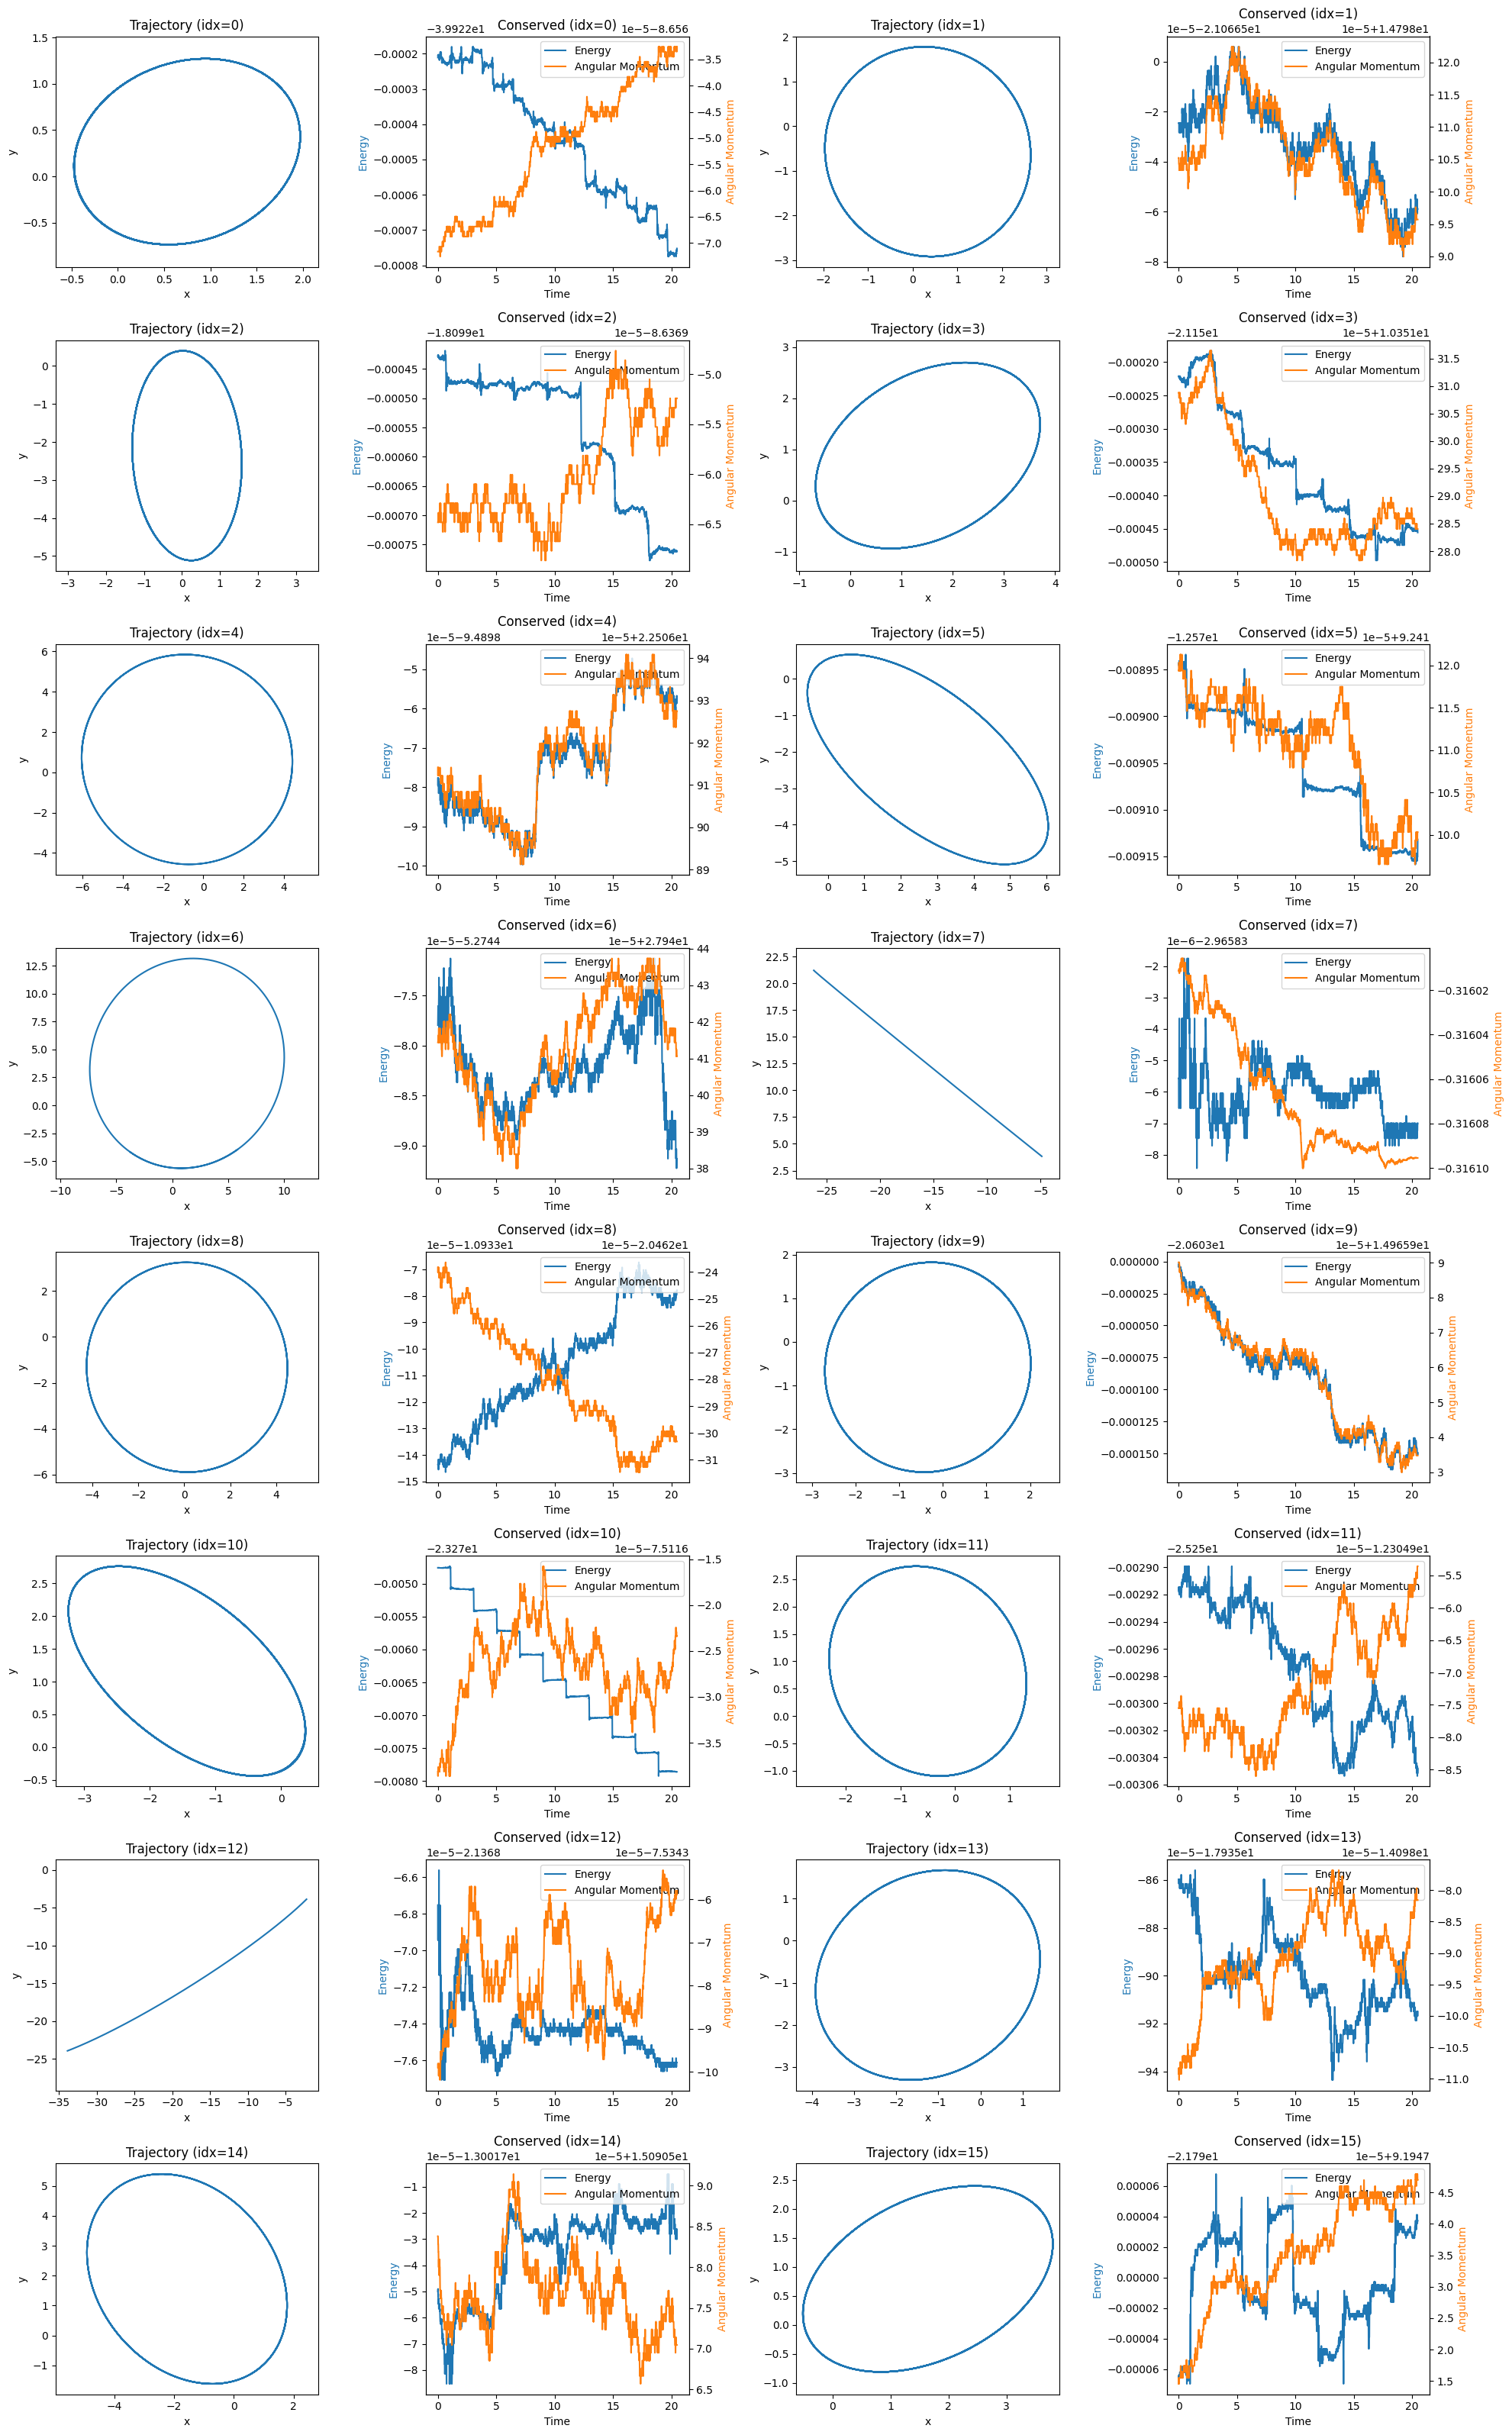

In [8]:
dt = 0.01
ts = jnp.arange(0, n_steps * dt, dt) + dt

n_indices = 16
n_per_row = 2
n_rows = n_indices // n_per_row
n_cols = 4  # [traj, cons] x 2

# subplot 생성
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 4 * n_rows))

for i in range(n_rows):
    idx0 = 2 * i
    idx1 = idx0 + 1

    for j, idx in enumerate([idx0, idx1]):
        col_traj = j * 2
        col_cons = j * 2 + 1

        # ── trajectory ──
        ax_traj = axes[i, col_traj]
        xs = trajectories[idx, :, :2]
        ax_traj.plot(xs[:, 0], xs[:, 1])
        ax_traj.set_title(f"Trajectory (idx={idx})")
        ax_traj.set_xlabel("x")
        ax_traj.set_ylabel("y")
        ax_traj.axis("equal")

        # ── conserved quantities ──
        ax_cons = axes[i, col_cons]
        ax2 = ax_cons.twinx()
        energy = consv_quants[idx, :, 0]
        angmom = consv_quants[idx, :, 1]

        line1 = ax_cons.plot(ts, energy, label='Energy', color='tab:blue')
        line2 = ax2.plot(ts, angmom, label='Angular Momentum', color='tab:orange')

        ax_cons.set_xlabel("Time")
        ax_cons.set_ylabel("Energy", color='tab:blue')
        ax2.set_ylabel("Angular Momentum", color='tab:orange')

        # 범례 통합
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax_cons.legend(lines, labels, loc='upper right')

        ax_cons.set_title(f"Conserved (idx={idx})")

plt.tight_layout()
plt.show()


In [22]:
# YOUR CODE HERE (15pts)

# RE-DESIGN OR USE CONSERVNET
# YOUR NEURAL NETWORK CODE HERE

class ConservNet(eqx.Module):
    net: eqx.nn.Sequential
    
    def __init__(
        self, 
        hidden_size: int=160,
        *,
        key: PRNGKeyArray    
    ):
        key1, key2, key3, key4, key5 = jax.random.split(key, 5)
        self.net = eqx.nn.Sequential([
            eqx.nn.Linear(4, hidden_size, key=key1),
            eqx.nn.Lambda(jax.nn.mish),
            eqx.nn.Linear(hidden_size, hidden_size, key=key2),
            eqx.nn.Lambda(jax.nn.mish),
            eqx.nn.Linear(hidden_size, hidden_size, key=key3),
            eqx.nn.Lambda(jax.nn.mish),
            eqx.nn.Linear(hidden_size, hidden_size, key=key4),
            eqx.nn.Lambda(jax.nn.mish),
            eqx.nn.Linear(hidden_size, 2, use_bias=False, key=key5)
        ])

    def __call__(self, x):
        out = self.net(x)
        return out
    
def xavier_normal(weight: jax.Array, key: jax.random.PRNGKey) -> jax.Array:
    out, inp = weight.shape
    gain = jnp.sqrt(2.0)
    std = gain * jnp.sqrt(2.0 / (inp + out))
    return std * jax.random.normal(key, (out, inp))

def apply_xavier_init(model: eqx.Module, key: jax.random.PRNGKey) -> eqx.Module:
    leaves, treedef = jax.tree_util.tree_flatten(model)
    num_weights = sum(isinstance(leaf, jnp.ndarray) and leaf.ndim == 2 for leaf in leaves)
    subkeys = jax.random.split(key, num_weights)
    idx = 0
    new_leaves = []
    for leaf in leaves:
        if isinstance(leaf, jnp.ndarray) and leaf.ndim == 2:
            new_leaves.append(xavier_normal(leaf, subkeys[idx]))
            idx += 1
        elif isinstance(leaf, jnp.ndarray) and leaf.ndim == 1:
            new_leaves.append(jnp.zeros_like(leaf))
        else:
            new_leaves.append(leaf)
    return jax.tree_util.tree_unflatten(treedef, new_leaves) 

In [26]:
# YOUR CODE HERE (15pts)

# RE-DESIGN OR USE CONSERVNET
# YOUR LOSS FUNCTION CODE HERE
@eqx.filter_value_and_grad
def compute_grad(
    model: eqx.Module, 
    traj: Float[Array, "B T D"], 
    noise: Float[Array, "B T D"],
    Q: float
):
    out = jax.vmap(jax.vmap(model))(traj) # (B, T, 4) -> (B, T, 2)
    var_orig = jnp.var(out, axis=1)
    
    out_perturbed = jax.vmap(jax.vmap(model))(traj + noise)
    var_perturbed = jnp.var(out_perturbed, axis=1)
    
    loss = jnp.mean(var_orig) + jnp.mean(jnp.clip(Q - var_perturbed, min=0))
    return loss
    

In [ ]:
# YOUR CODE HERE (5pts)

# YOUR NEURAL NETWORK TRAINING CODE HERE
def data_loader(
    trajectories: Float[Array, "N T D"],
    batch_size: int,
    group_size: int,
    *,
    key, 
    infinite=False
):
    n_traj, traj_len, _ = trajectories.shape
    slices = jnp.reshape(
        trajectories[:,:(traj_len // group_size) * group_size], 
        (-1, group_size, 4)
    )
    dataset_size = slices.shape[0]
    indices = jnp.arange(dataset_size)
    
    while True:
        key, subkey = jax.random.split(key)
        perm = jax.random.permutation(subkey, indices)
        for start in range(0, dataset_size, batch_size):
            batch_idx = perm[start:start + batch_size]
            yield slices[batch_idx]
        
        if not infinite:
            break
    
def train(
    model: eqx.Module,
    optim: optax.GradientTransformation,
    opt_state: optax.OptState,
    data: Float[Array, "N T D"],
    batch_size: int,
    group_size: int,
    n_epochs: int,
    noise_std: float,
    Q: float,
    *,
    key: PRNGKeyArray
):
    @eqx.filter_jit
    def make_step(
        model: eqx.Module,
        opt_state: optax.OptState,
        traj_slices: Float[Array, "B T D"],
        key: PRNGKeyArray,
    ):
        key, new_key = jax.random.split(key)
        noise = jax.random.uniform(key, traj_slices.shape) * noise_std
        loss, grad = compute_grad(model, traj_slices, noise, Q)
        updates, new_opt_state = optim.update(
            grad, opt_state, eqx.filter(model, eqx.is_inexact_array)
        )
        model = eqx.apply_updates(model, updates)
        grad_flat, _ = jax.flatten_util.ravel_pytree(grad)
        grad_norm = jnp.linalg.norm(grad_flat)
        return model, new_opt_state, new_key, loss, grad_norm
    
    n_traj, traj_len, _ = data.shape
    batches_per_epoch = n_traj * (traj_len // group_size) // batch_size
    
    loader_key, key = jax.random.split(key)
    train_loader = data_loader(data, batch_size, group_size, key=loader_key, infinite=True)
    step_iter = iter(train_loader)
    
    train_losses = np.zeros((n_epochs, batches_per_epoch))
    train_gradns = np.zeros((n_epochs, batches_per_epoch))
    pbar = tqdm(total=n_epochs * batches_per_epoch, desc=f"Epoch 0/{n_epochs}", unit="iterations")
    for epoch in range(n_epochs):
        pbar.set_description(f"Epoch {epoch+1}/{n_epochs}")
        for i in range(batches_per_epoch):
            slices = next(step_iter)
            model, opt_state, key, loss, grad_norm = make_step(
                model, opt_state, slices, key
            )
            train_losses[epoch, i] = float(loss)
            train_gradns[epoch, i] = float(grad_norm)
            pbar.update()
            pbar.set_postfix(loss=loss, gradnorm=grad_norm)
            
    return model, opt_state, train_losses, train_gradns

def plot_metrics(losses, gradnorms):

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.set_yscale('log')
    ax1.plot(losses, color='tab:blue', label='Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Grad Norm', color='tab:red')
    ax2.set_yscale('log')
    ax2.plot(gradnorms, color='tab:red', alpha=0.5, label='Grad Norm')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()
    plt.title('Training Metrics')
    plt.show()
    
model_key, key = jax.random.split(key)
model = ConservNet(hidden_size=160, key=jax.random.key(0)) # dummy key
model = apply_xavier_init(model, key=model_key)


batch_size = 64
group_size = 512
n_epochs = 10
start_learning_rate = 5e-5
optim = optax.adam(start_learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

trainer_key, key = jax.random.split(key)

# training
noise_std = 1.
Q = 1.
model, opt_state, train_losses, train_gradns = train(
    model, optim, opt_state, trajectories, 
    batch_size, group_size, n_epochs, 
    noise_std, Q, 
    key=trainer_key
)
plot_metrics(train_losses, train_gradns)

Epoch 0/20:   0%|          | 0/5120 [00:00<?, ?iterations/s]

StopIteration: 

In [ ]:
# YOUR CODE HERE (5pts)

# YOUR VISUALIZATION CODE HERE

### Discuss the results (15pts)

DISCUSSING THE ANALYSIS RESULTS (in 500 words, include graphics or tables by using markdown is fine)

### 2. Explore potential methods or strategies to further enhance the performance of PINNs. (review articles, or just consideration is fine) (40pts)

REVIEW RECENTLY METHODS OR STRATEGIES (in 500 words, include graphics or tables by using markdown is fine, ADD REFERENCE)